<a href="https://colab.research.google.com/github/vipulSharma18/Automatic-Emotion-Recognition-on-DEAP-Dataset/blob/main/models/2_level_Ensemble_of_Light_Pyramidal_1D_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Add Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing Relevant Libraries

In [2]:
import pandas as pd
import tensorflow as tf
import numpy as np
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Softmax
from sklearn.metrics import classification_report
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pickle
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import gc

# GPU Check

In [3]:
print(tf.version.VERSION)
print(tf.config.experimental.list_physical_devices('GPU'))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.4.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1


# Data Augmentation

## Load Data from .dat files into a np array of 1280 x 32 x 8064 size

In [4]:
all_sub_data = []
subjects_list = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32']
for sub in subjects_list:
    path = "/content/drive/MyDrive/major project/data_preprocessed_python/s"+sub+".dat"
    x = pickle.load(open(path, 'rb'), encoding = 'latin1')
    sub_data = x['data']
    sub_eeg = sub_data[:, :32, :]  #indexing EEG signals from physiological data
    all_sub_data.extend(sub_eeg)
    gc.collect()
gc.collect()
all_sub_data = np.array(all_sub_data)

In [5]:
all_sub_data.shape

(1280, 32, 8064)

## Z-score normalization of each EEG signal, resultant np.array is all_sub_data

In [6]:
for sub in range(all_sub_data.shape[0]):
  all_sub_data[sub] = zscore(all_sub_data[sub], axis = 1)  #zscore normalize each channel
gc.collect()

22

## Label Loading into np array of 1280 x 1 named, sub_labels

In [7]:
labels = pd.read_excel("/content/drive/MyDrive/major project/metadata/Labels.xls")
sub_labels = labels["Valence-Arousal Model Quadrant"].astype('int')
sub_labels
gc.collect()

3058

## One-Hot encoding of labels  
> sub_labels: (1280,4)

In [8]:
lb = preprocessing.LabelBinarizer()
sub_labels = lb.fit_transform(sub_labels)
print(lb.classes_)
print(sub_labels.shape)
print(sub_labels)

[0 1 2 3]
(1280, 4)
[[0 0 0 1]
 [0 0 0 1]
 [0 0 0 1]
 ...
 [0 1 0 0]
 [0 1 0 0]
 [0 0 1 0]]


In [9]:
sub_labels.shape

(1280, 4)

In [10]:
gc.collect()

0

## Generating Train Test Splits,  
> X_train, y_train: (1152,32,8064), (1152,4)  
> X_test, y_test: (128,32,8064), (128,4)  

In [11]:
X_train, X_test, y_train, y_test = train_test_split(all_sub_data, sub_labels, test_size = 0.1, random_state = 42,shuffle = True)

In [12]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1152, 32, 8064), (1152, 4), (128, 32, 8064), (128, 4))

In [13]:
del(all_sub_data)
del(sub_labels)
del(labels)
del(x)
del(sub_data)
del(sub_eeg)
del(subjects_list)
gc.collect()

0

## Repetition of Labels for Windowing of training data  

> y_train_12, y_train_6, y_train_4 of shapes(?,4): 13824, 6912 and 4608 respectively 


In [14]:
#12,6 and 4 subsignals are generated from 8064 length EEG signal, labels repeated accordingly
y_train_12 = np.repeat(y_train, 12, axis = 0)
y_train_6 = np.repeat(y_train, 6, axis = 0)
y_train_4 = np.repeat(y_train, 4, axis = 0)
del(y_train)
gc.collect()
print(y_train_12.shape, y_train_6.shape, y_train_4.shape)

(13824, 4) (6912, 4) (4608, 4)


## Loading Training data with different window sizes

In [15]:
del(X_train)
gc.collect()

0

### 12 sub signals of length 672 each, total 13824 instances

In [16]:
X_train_12 = np.load("/content/drive/MyDrive/major project/data_augmentation/channel_wise_12.npy")
print(X_train_12.shape, 'Shape of Training Data')
gc.collect()

(32, 13824, 672, 1) Shape of Training Data


3

### 6 sub signals of length 1344 each, total 6912 instances

In [17]:
#X_train_6 = np.load("/content/drive/MyDrive/major project/data_augmentation/channel_wise_6.npy")
#print(X_train_6.shape, 'Shape of Training Data')
#gc.collect()

### 4 sub signals of length 2016 each, total 4608 instances

In [18]:
#X_train_4 = np.load("/content/drive/MyDrive/major project/data_augmentation/channel_wise_4.npy")
#print(X_train_4.shape, 'Shape of Training Data')
#gc.collect()

In [19]:
gc.collect()

0

# Lightweight Pyramidal 1D CNN model

In [99]:
def create_models(dense_par=20, sub_signals=12):
  sample_size = int(8064/sub_signals)
  models = [0]*32
  for i in range(32):
    models[i] = Sequential()
    #block 1
    models[i].add(Conv1D(filters=32, kernel_size=5,strides = 3, input_shape=(sample_size, 1)))
    models[i].add(BatchNormalization())
    models[i].add(tf.keras.layers.Activation('relu'))
    #block 2
    models[i].add(Conv1D(filters=24, kernel_size=3,strides = 2))
    models[i].add(BatchNormalization())
    models[i].add(tf.keras.layers.Activation('relu'))
    #block 3
    models[i].add(Conv1D(filters=16, kernel_size=3,strides = 2))
    models[i].add(BatchNormalization())
    models[i].add(tf.keras.layers.Activation('relu'))
    #block 4
    models[i].add(Conv1D(filters=8, kernel_size=3,strides = 2))
    models[i].add(BatchNormalization())
    models[i].add(tf.keras.layers.Activation('relu'))
    #fc-1
    models[i].add(Flatten())
    models[i].add(Dense(dense_par, activation='relu'))
    #dropout
    models[i].add(Dropout(rate = 0.5))
    #fc2 and softmax
    models[i].add(Dense(4, activation = 'softmax'))
    models[i].compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.0001,beta_1=0.9,beta_2=0.999,epsilon=1e-08) , loss = tf.keras.losses.CategoricalCrossentropy(), metrics= 'accuracy')
  print("All models defined.")
  return models

In [100]:
gc.collect()

0

In [101]:
def plot_evaluation_curves(history, EPOCHS):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(EPOCHS)

  plt.figure(figsize=(10, 6))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

## Training using 12 sub_signals per EEG signal

All models defined.
Individual Net : 1
CNN Model 1: Epochs=200, Training accuracy=0.43815, Validation accuracy=0.43239


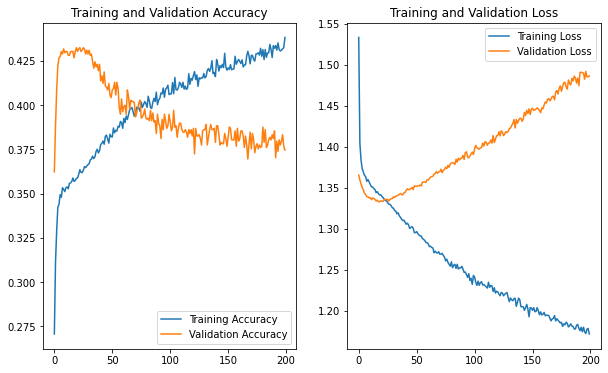

0

In [39]:
models = create_models(dense_par=20, sub_signals = 12)
history = [0]*32
epochs = 200
for j in range(1):
  print(f'Individual Net : {j+1}')   
  history[j] = models[j].fit(X_train_12[j], y_train_12, epochs = epochs, verbose = 0, validation_split=0.1)
  print("CNN Model {0:d}: Epochs={1:d}, Training accuracy={2:.5f}, Validation accuracy={3:.5f}".format(j+1,epochs,max(history[j].history['accuracy']),max(history[j].history['val_accuracy']) ))
  plot_evaluation_curves(history[j], epochs)
  gc.collect()
gc.collect()


In [45]:
# Fresh Start to training with freeing up of RAM
try:
  del models
  del history
except:
  print("Variables already freed")
gc.collect()

Variables already freed


110

## Preprocessing for passing test data into CNN

In [ ]:
def process_input_ensemble(instances, sub_signals):
  #instances must be channel wise of shape (-1, 32, 8064)
  gc.collect()
  samples = int(8064/sub_signals)
  transformed = []
  for i in range(instances.shape[0]):
    transformed.append(np.reshape(instances[i], (-1,sub_signals,samples,1)))
    gc.collect()
  transformed = np.array(transformed)
  print(transformed.shape, 'is the shape obtained.')
  gc.collect()
  #output shape will be (len(intances), 32, sub_signals, samples, 1)
  return transformed

## Testing Algorithm:

In [ ]:
#loop over test instances i.e. 128
  #loop over 32 channels i.e. 1 model for each channel
    #for each channel, pass the shape (sub_singals,samples,1) to M(i), here sub_signals will be the batch_size
    #get all predictions for a single channel's all samples, take their mode. This is the prediction for that channel
    #store all the channels' predicitions in an array
  #take mode for all channels' predictions from array, this is the predicted value for that instance